# Practical Application III: Comparing Classifiers - Marketing Campaign Analysis

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## Imports & Utilities

In [4]:
# CONSTANTS FOR THE PROJECT
class Config:
    RANDOM_STATE = 42
    SUPPRESS_OUTPUT_FILES=False
    PAGE_WIDTH = 10
    TARGET_COLORS = ('indianred', 'seagreen')
    # TARGET_COLORS = ('red', 'green')


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

# Export dataFrame's as images
import dataframe_image as dfi

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [6]:
# Configure logging
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%I:%M:%S %p')
# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

# Switching logging config requires kernel restart - uncomment the test below to quickly verify settings
# logging.info("Logging output test")

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [7]:
def time_secs_to_msg(lapse_time_secs, mins_label='m', secs_label='s'):
    if lapse_time_secs <= 60:
        return f'{lapse_time_secs%60:.2f}{secs_label}'
    else:
        return f'{lapse_time_secs//60:,.0f}{mins_label} {lapse_time_secs%60:.2f}{secs_label}'

In [8]:
def build_results_row(name, model, Xtr, Xte, ytr, yte, use_best=False):
    """
    Given the model and training/test sets, builds a row of metrics for reporting the results

    :param name: Name/Description of model
    :param model: Fully constructed model instance - will call fit() and predict() to get metrics
    :param Xtr: X_train - scale before calling
    :param Xte: X_test - scale before calling
    :param ytr: Y_train set
    :param yteL: Y_test set
    """
    
    print(f'{name}: Starting', flush=True)
    start_time = time.time()

    # train the model
    clf = model.fit(Xtr, ytr)

    # if we're tuning then use best_estimator
    if use_best:
        clf = model.best_estimator_
        logging.debug(f'{name}: Best Model={clf}')
        logging.debug(f'{name}: Best Params={model.best_params_}')

    # Save fit time
    fit_time = time.time() - start_time
    logging.debug(f'{name}: Fitted')

    # get the predictions / probabilities
    y_preds = clf.predict(Xte)
    y_probs = clf.predict_proba(Xte)[:, 1]
    cm = confusion_matrix(yte, y_preds)
    logging.debug(f'{name}: Got preds/probs')

    # Get metrics
    row = {
        'Train Time': time_secs_to_msg(fit_time),
        'Train Accuracy': f'{model.score(Xtr, ytr)*100:.2f}%',
        'Test Accuracy': f'{model.score(Xte, yte)*100:.2f}%',
        'Precision': f'{precision_score(yte, y_preds)*100:.2f}%',
        'Recall': f'{recall_score(yte, y_preds)*100:.2f}%',
        'F1': f'{f1_score(yte, y_preds)*100:.2f}%',
        'AUC': f'{roc_auc_score(yte, y_probs)*100:.2f}%',
        'preds': y_preds,
        'probs': y_probs,
        'cm': cm,
        'TN': f'{cm[0, 0]:,d}',
        'FP': f'{cm[0, 1]:,d}',
        'FN': f'{cm[1, 0]:,d}',
        'TP': f'{cm[1, 1]:,d}',
        'best_params': None
    }
    if use_best:
        row.update({'best_params': model.best_params_})
    logging.debug(f'{name}: Got metrics')
    
    print(f'{name}: Done: {time_secs_to_msg(time.time()-start_time)}')

    return row

## Exploratory Data Analysis (EDA)

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This data is a collection of results from 17 Direct Marketing (DM) phone campaign conducted by a Portugese Bank (Customer) between May 2008 and November 2010, corressponding to 79,354 contacts, who were offered attractive, long-term deposit applications. As you can see below, for each contact, various demographic and bank relationship attributes are provided. A separate column `y` has been provided showing whether the offer was accepted or not, i.e. was the capaign successful or not. We will now explore this data to develop an understanding of it's characteristics so that we can generate machine learning (ML) models to help the Customer optimize their future DM campaigns and improve the likelihood of the campaign offer being accepted. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [13]:
# orig_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
orig_df = pd.read_csv('data/bank-additional.csv', sep = ';')

In [14]:
orig_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [16]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

### Inspect: Nulls

In [18]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
orig_df.isnull().sum().transform(lambda x: (1 - (x / orig_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


age               100.0
job               100.0
marital           100.0
education         100.0
default           100.0
housing           100.0
loan              100.0
contact           100.0
month             100.0
day_of_week       100.0
duration          100.0
campaign          100.0
pdays             100.0
previous          100.0
poutcome          100.0
emp.var.rate      100.0
cons.price.idx    100.0
cons.conf.idx     100.0
euribor3m         100.0
nr.employed       100.0
y                 100.0
dtype: float64

No nulls - looking good!

### Inspect: Overall Features

Let's take a quick look at the feature distributions to see if anything jumps out:

In [22]:
categorical_cols = orig_df.select_dtypes(include=['object']).columns
numerical_cols = orig_df.select_dtypes(exclude=['object']).columns.tolist()

02:37:11 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
02:37:11 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
02:37:11 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
02:37:11 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


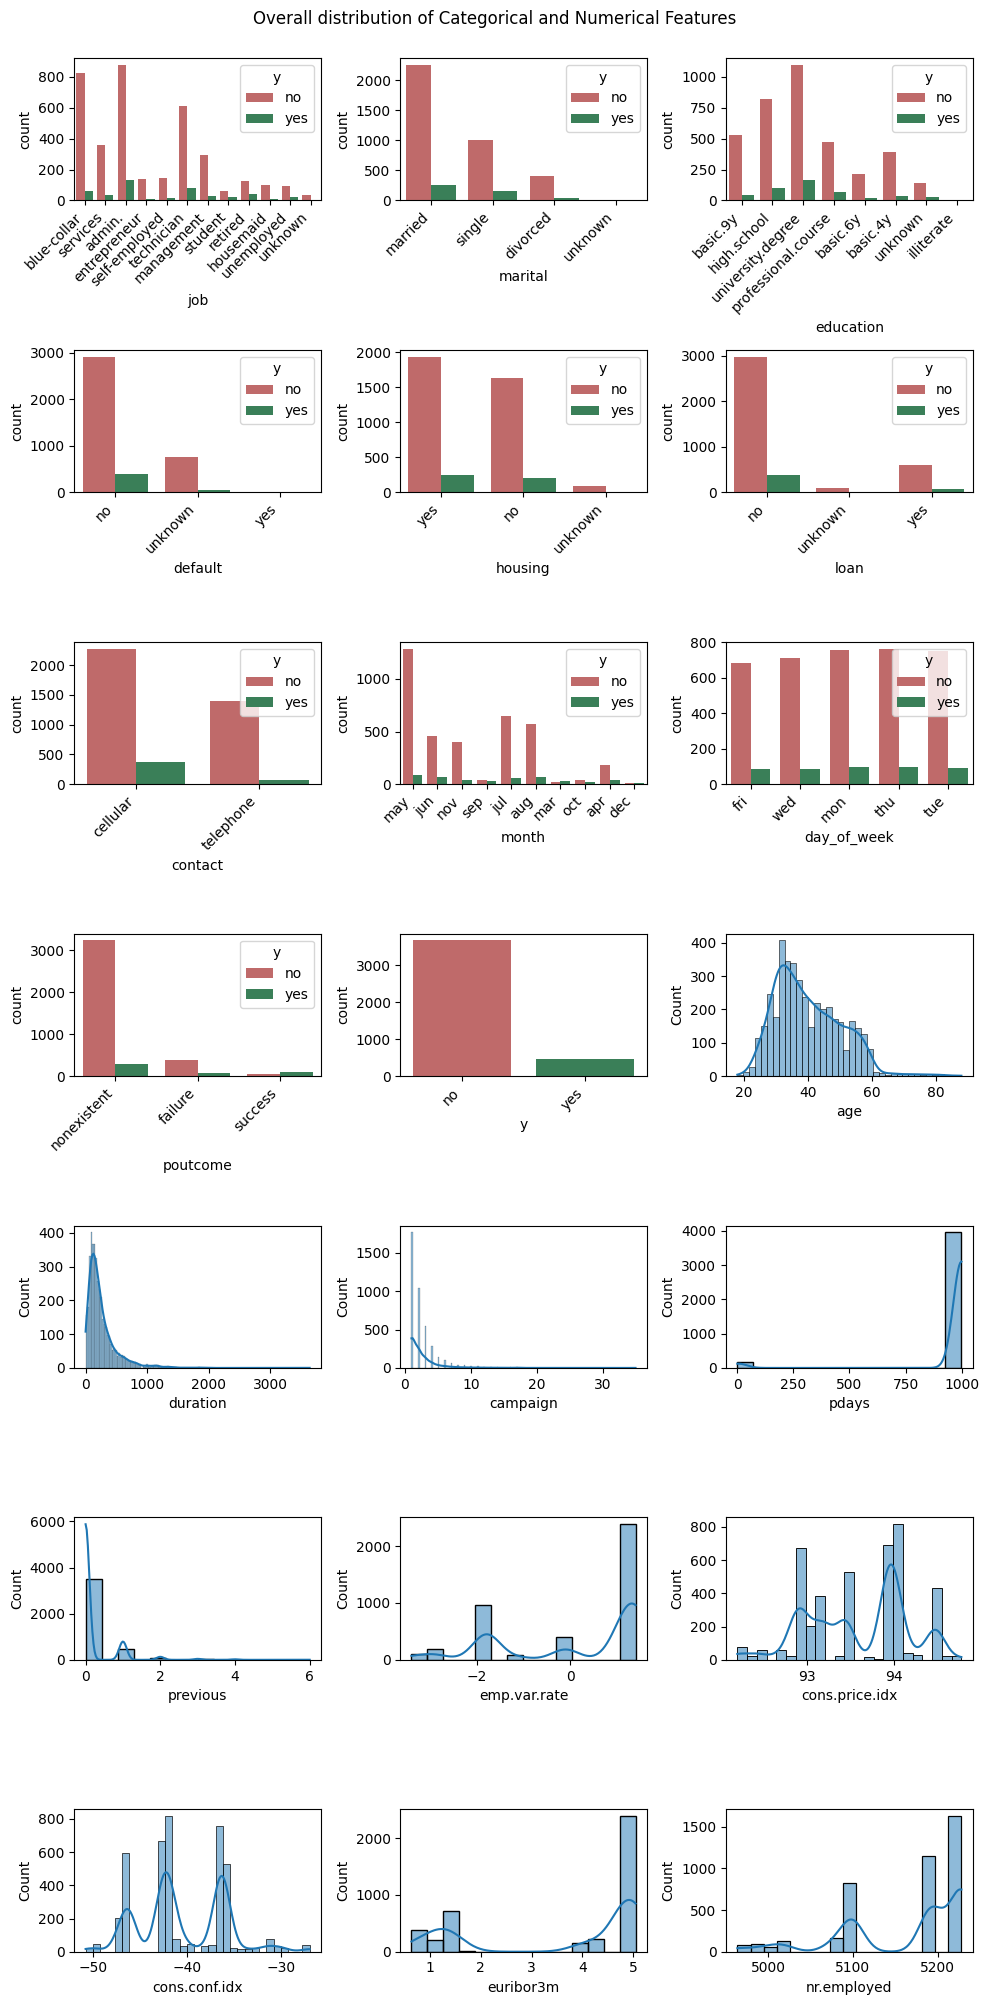

In [23]:
fig, axes = plt.subplots(7,3, figsize=(Config.PAGE_WIDTH, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate countplots for each categorical feature
for i, col in enumerate(categorical_cols):
    sns.countplot(ax=axes[i], x=col, data=orig_df, hue='y', palette=Config.TARGET_COLORS)
    # axes[i].set_title(f'Countplot of {col}')
    # Rotate x-axis labels by 45 degrees
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

# Generate histograms for numerical features
for j, col in enumerate(numerical_cols, start=len(categorical_cols)):
    sns.histplot(orig_df[col], ax=axes[j], kde=True)
    # axes[j].set_title(f'Histogram of {col}')

# Hide any unused subplots
for k in range(len(categorical_cols) + len(numerical_cols), len(axes)):
    fig.delaxes(axes[k])

plt.suptitle('Overall distribution of Categorical and Numerical Features', y=1.0)

# Adjust layout to prevent overlap
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/feature_distributions.png')

plt.show()

We don't have any nulls and the overall distributions look reasonable - we can't exclude anything at this stage as it may be relevant for modeling.

Some data concerns that we can note for now and may have to come back to them:

* `unknown` values for `marital`, `default`, `housing` and `loan` columns: I'm ignoring them for now, but if these features are important during modeling, then we may have to understand the significance of these values. This is specially concerning for `default` cases where the `unknown` value is significant
* `pdays` distribution shows that majority of the resepondents were not previously contacted (999), so this may be a red flag for removing this column

### Inspect: Target = Campaign Acceptance 

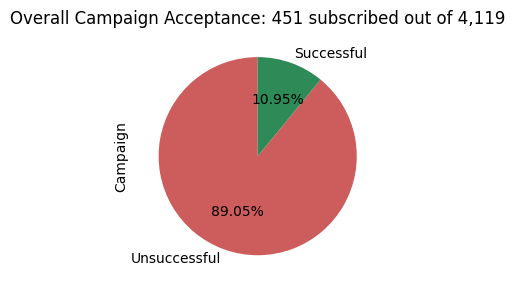

In [26]:
# Prep data for Pie chart
acceptance_rate_pie = orig_df.groupby('y')['y'].value_counts().rename('Campaign').reset_index()

# Calculate overall acceptance rate
nayes = acceptance_rate_pie.iloc[0, 1]
ayes = acceptance_rate_pie.iloc[1, 1]
acceptance_rate = (ayes / orig_df.shape[0]) * 100

names = ('Unsuccessful','Successful')
plt.rcParams['figure.figsize'] = (6,3)

acceptance_rate_pie.plot.pie(y='Campaign',
                             autopct='%1.2f%%', labels=names, legend=False,
                             colors=Config.TARGET_COLORS, startangle=90)
plt.title(f'Overall Campaign Acceptance: {ayes:,d} subscribed out of {orig_df.shape[0]:,d}')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pie-acceptance-overall.png')

plt.tight_layout()
plt.show()

### Inspect: Feature corelations

**To understand the feature correlations, I generated the Seaborn ``pairplot`` - it takes time to generate so the saved image is used instead**
```
sns.pairplot(orig_df, hue='y')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pairplot_raw_features.png')
    
plt.show()
```
![](images/pairplot_raw_features.png)

### Problem 4: Understanding the Task

**Business Objective**

This data is a collection of results from 17 Direct Marketing (DM) phone campaign conducted by a Portugese Bank (Customer) between May 2008 and November 2010, corressponding to 79,354 contacts, who were offered attractive, long-term deposit applications. As you can see below, for each contact, various demographic and bank relationship attributes are provided. A separate column `y` has been provided showing whether the offer was accepted or not, i.e. was the capaign successful or not. Our business objective is to help the Customer optimize their DM campagns in the future by predicting the likelihood of the campaign offer being accepted based on this data. 

In [30]:
orig_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no


## Data Modeling

### Problem 5: Engineering Features

Now that we understand our business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Let's dig a little deeper - first we'll make a copy of the original data and transform it to aid our analysis:

In [34]:
encoded_df = orig_df.copy()

In [35]:
# Convert categorical variable to numeric data for the models to digest it
for col in categorical_cols:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

Let's quickly check to see how our target variable looks against the other feature attributes for any red flags:

_To understand the feature correlations, I generated the Seaborn ``pairplot`` - it takes time to generate so the saved image is used instead_
```
sns.pairplot(encoded_df, hue='y', y_vars='y')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pairplot_raw_encoded_features_vs_y.png')
    
plt.show()
```
![](images/pairplot_raw_encoded_features_vs_y.png)

Let's look at the correlation among the variables:

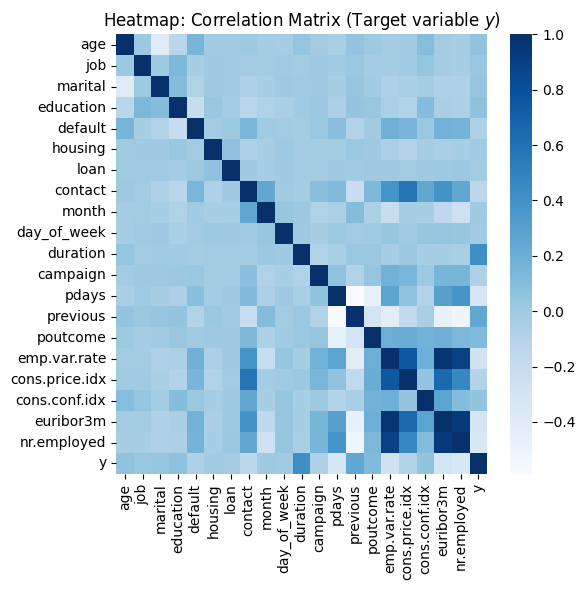

In [38]:
plt.figure(figsize=(6,6))
sns.heatmap(encoded_df.corr(), annot=False, cmap='Blues')

plt.title(f'Heatmap: Correlation Matrix (Target variable $y$)', y=1.0)
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/heatmap_cmatrix.png')
    
plt.show()

Most of the data seems to have reasonable correlations to the targe `y` variable - too early to eliminate any data till we get preliminary results from our models.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [41]:
# Create the feature matrices for independnet and target variables

X = encoded_df.drop('y', axis='columns')
y = encoded_df['y']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=Config.RANDOM_STATE)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat? We will use the Scikit ML Library provided `DummyClassifier` with `strategy='uniform'` that will make _untratined_ predictions with equal probability among the two possible classes: Successful and Unsuccessful, without taking any of the call features into account. 

In [44]:
logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [45]:
# Scale the data - we'll use StandardScaler for the baseline model
# scaler = StandardScaler()
scaler = MinMaxScaler()
logging.debug(f'Scaling data: {scaler}')

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

02:37:18 PM DEBUG: Scaling data: MinMaxScaler()


In [46]:
# let's start saving the results for reporting out
results = {}

# Reports won't print all the columns
report_cols = ['Train Time', 'Train Accuracy', 'Test Accuracy', 
               'Precision', 'Recall', 'F1', 'AUC', 'TN', 'FP', 'FN', 'TP']
report_cols_tuned = ['best_params', 'Train Time', 'Train Accuracy', 'Test Accuracy', 
                     'Precision', 'Recall', 'F1', 'AUC', 'TN', 'FP', 'FN', 'TP']

We are going to use a function `build_results_row` to build individual rows of our Model Report. Please see the Imports & Utililties section above for the source of this function:

In [48]:
help(build_results_row)

Help on function build_results_row in module __main__:

build_results_row(name, model, Xtr, Xte, ytr, yte, use_best=False)
    Given the model and training/test sets, builds a row of metrics for reporting the results
    
    :param name: Name/Description of model
    :param model: Fully constructed model instance - will call fit() and predict() to get metrics
    :param Xtr: X_train - scale before calling
    :param Xte: X_test - scale before calling
    :param ytr: Y_train set
    :param yteL: Y_test set



In [49]:
name = 'DummyClassifier'
model = DummyClassifier(strategy='uniform')

# Get metrics row for the report - will fit() and predict() to generate metrics
results[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
results_df = pd.DataFrame(results).T

results_df.loc[name:][report_cols]

DummyClassifier: Starting


02:37:18 PM DEBUG: DummyClassifier: Fitted
02:37:18 PM DEBUG: DummyClassifier: Got preds/probs
02:37:18 PM DEBUG: DummyClassifier: Got metrics


DummyClassifier: Done: 0.03s


,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
DummyClassifier,0.00s,50.68%,52.31%,13.97%,62.22%,22.81%,50.00%,389,345,34,56


In [50]:
print(classification_report(y_test, results[name]['preds'], target_names=['Unsuccessful', 'Successful']))

              precision    recall  f1-score   support

Unsuccessful       0.92      0.53      0.67       734
  Successful       0.14      0.62      0.23        90

    accuracy                           0.54       824
   macro avg       0.53      0.58      0.45       824
weighted avg       0.83      0.54      0.62       824



As expected, the predictions from the DummyClassifier are about as good as a coin toss, and this is the baseline score for our business use case!

### Problem 8: A Simple Model

Let's try a linear regression model to see if we can do better!

In [53]:
name = 'LogisticRegression'
model = LogisticRegression()

# Get metrics row for the report - will fit() and predict() to generate metrics
results[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
results_df = pd.DataFrame(results).T

results_df.loc[name:][report_cols]

LogisticRegression: Starting


02:37:18 PM DEBUG: LogisticRegression: Fitted
02:37:18 PM DEBUG: LogisticRegression: Got preds/probs
02:37:18 PM DEBUG: LogisticRegression: Got metrics


LogisticRegression: Done: 0.09s


,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
LogisticRegression,0.06s,91.29%,90.53%,56.00%,62.22%,58.95%,93.26%,690,44,34,56


### Problem 9: Score the Model

What is the accuracy of your model?

In [55]:
print(f'LogisticRegression Prediction Accuracy: {accuracy_score(y_test, results[name]["preds"]) * 100 :,.2f}%')

LogisticRegression Prediction Accuracy: 90.53%


In [56]:
print(classification_report(y_test, results[name]['preds'], target_names=['Unsuccessful', 'Successful']))

              precision    recall  f1-score   support

Unsuccessful       0.95      0.94      0.95       734
  Successful       0.56      0.62      0.59        90

    accuracy                           0.91       824
   macro avg       0.76      0.78      0.77       824
weighted avg       0.91      0.91      0.91       824



As we can see, the default `LogisticRegression` did much better out of the gate than the _dumb_ model, 50% vs over 90%! Let's see if we can do better now with more sophisticated models.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models by using the default settings of the models to fit and score each one.

In [59]:
# Define the default models
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(probability=True)
}

for name, model in models.items():
    # Get metrics row for the report - will fit() and predict() to generate metrics
    results[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

KNeighborsClassifier: Starting


02:37:19 PM DEBUG: KNeighborsClassifier: Fitted
02:37:19 PM DEBUG: KNeighborsClassifier: Got preds/probs
02:37:19 PM DEBUG: KNeighborsClassifier: Got metrics


KNeighborsClassifier: Done: 0.40s
DecisionTreeClassifier: Starting


02:37:19 PM DEBUG: DecisionTreeClassifier: Fitted
02:37:19 PM DEBUG: DecisionTreeClassifier: Got preds/probs
02:37:19 PM DEBUG: DecisionTreeClassifier: Got metrics


DecisionTreeClassifier: Done: 0.04s
SVC: Starting


02:37:20 PM DEBUG: SVC: Fitted
02:37:20 PM DEBUG: SVC: Got preds/probs
02:37:21 PM DEBUG: SVC: Got metrics


SVC: Done: 1.52s


In [60]:
results_defaults_df = pd.DataFrame(results).T.sort_values(by='Test Accuracy', ascending=False)

if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_defaults_df[report_cols], 'images/table_models_defaults.png')

results_defaults_df[report_cols]

02:37:24 PM DEBUG: STREAM b'IHDR' 16 13
02:37:24 PM DEBUG: STREAM b'iCCP' 41 296
02:37:24 PM DEBUG: iCCP profile name b'Skia'
02:37:24 PM DEBUG: Compression method 0
02:37:24 PM DEBUG: STREAM b'IDAT' 349 8192


,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
SVC,0.99s,90.71%,90.66%,70.97%,24.44%,36.36%,91.64%,725,9,68,22
LogisticRegression,0.06s,91.29%,90.53%,56.00%,62.22%,58.95%,93.26%,690,44,34,56
KNeighborsClassifier,0.00s,91.05%,89.56%,57.14%,17.78%,27.12%,73.04%,722,12,74,16
DecisionTreeClassifier,0.02s,100.00%,78.16%,26.32%,55.56%,35.71%,68.24%,594,140,40,50
DummyClassifier,0.00s,50.68%,52.31%,13.97%,62.22%,22.81%,50.00%,389,345,34,56


We can now compare the results from all our base Models! The best performing model with the highest Test Accuracy Score on the validation data is `SVC`, i.e. after being trained on the training data, how it does against the held-out test dataset in correctly predicting the offer acceptance (both positive and negative) across all calls.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree 
- Adjust our performance metrics

In [63]:
# Define the models to be tuned
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(probability=True, max_iter=10000)
}

param_grid = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
    },
    
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'SVC': {
        # 'C': [0.1, 1, 10, 100],
        'C': np.logspace(-3, 4, 5),
        'kernel': ['linear', 'poly', 'rbf'],
        'degree': [1, 3],    # For poly only - 5 didn't win
        'gamma': ['scale', 'auto'],
    }
}

In [64]:
np.logspace(-3, 4, 5)

array([1.00000000e-03, 5.62341325e-02, 3.16227766e+00, 1.77827941e+02,
       1.00000000e+04])

In [65]:
# Perform GridSearchCV
CV=5
VERBOSE=3
results = {}

for name, model in models.items():
    
    print(f'{name}: Starting GridSearchCV optimization ({CV}-fold)', flush=True)
    grid_search = GridSearchCV(model, param_grid=param_grid[name], scoring='accuracy',
                              cv=CV, verbose=VERBOSE)
    
    results[name] = build_results_row(name, grid_search, X_train_scaled, X_test_scaled, y_train, y_test, use_best=True)
    print(f'{name}: Done GridSearchCV optimization ({CV}-fold)', flush=True)

LogisticRegression: Starting GridSearchCV optimization (5-fold)
LogisticRegression: Starting
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.733 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.684 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.713 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.739 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.718 total time=   0.0s
[CV 1/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.733 total time=   0.1s
[CV 2/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.684 total time=   0.0s
[CV 3/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.713 total time=   0.0s
[CV 4/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.739 total time=   0.0s
[CV 5/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, penal

02:37:31 PM DEBUG: LogisticRegression: Best Model=LogisticRegression(C=10, class_weight='balanced', max_iter=1000, solver='saga')
02:37:31 PM DEBUG: LogisticRegression: Best Params={'C': 10, 'penalty': 'l2', 'solver': 'saga'}
02:37:31 PM DEBUG: LogisticRegression: Fitted
02:37:31 PM DEBUG: LogisticRegression: Got preds/probs
02:37:31 PM DEBUG: LogisticRegression: Got metrics


LogisticRegression: Done: 6.81s
LogisticRegression: Done GridSearchCV optimization (5-fold)
KNeighborsClassifier: Starting GridSearchCV optimization (5-fold)
KNeighborsClassifier: Starting
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.891 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.895 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.891 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.891 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.885 total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.894 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.894 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.891 total time=   0.0s
[C

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
02:37:40 PM DEBUG: KNeighborsClassifier: Best Model=KNeighborsClassifier(n_neighbors=11, weights='distance')
02:37:40 PM DEBUG: KNeighborsClassifier: Best Params={'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}
02:37:40 PM DEBUG: KNeighborsClassifier: Fitted
02:37:41 PM DEBUG: KNeighborsClassifier: Got preds/probs
02:37:41 PM DEBUG: KNeighborsClassifier: Got metrics


[CV 5/5] END algorithm=brute, n_neighbors=11, weights=distance;, score=0.891 total time=   0.1s
KNeighborsClassifier: Done: 9.35s
KNeighborsClassifier: Done GridSearchCV optimization (5-fold)
DecisionTreeClassifier: Starting GridSearchCV optimization (5-fold)
DecisionTreeClassifier: Starting
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.871 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.900 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.859 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.873 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.897 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_sample

02:37:59 PM DEBUG: DecisionTreeClassifier: Best Model=DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10)
02:37:59 PM DEBUG: DecisionTreeClassifier: Best Params={'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
02:37:59 PM DEBUG: DecisionTreeClassifier: Fitted
02:37:59 PM DEBUG: DecisionTreeClassifier: Got preds/probs


[CV 4/5] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=0.894 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=0.910 total time=   0.0s


02:37:59 PM DEBUG: DecisionTreeClassifier: Got metrics


DecisionTreeClassifier: Done: 18.85s
DecisionTreeClassifier: Done GridSearchCV optimization (5-fold)
SVC: Starting GridSearchCV optimization (5-fold)
SVC: Starting
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.889 total time=   3.5s
[CV 2/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.891 total time=   1.0s
[CV 3/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.891 total time=   2.0s
[CV 4/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.891 total time=   0.8s
[CV 5/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.891 total time=   0.9s
[CV 1/5] END C=0.001, degree=1, gamma=scale, kernel=poly;, score=0.889 total time=   0.6s
[CV 2/5] END C=0.001, degree=1, gamma=scale, kernel=poly;, score=0.891 total time=   3.9s
[CV 3/5] END C=0.001, degree=1, gamma=scale, kernel=poly;, score=0.891 total time=   1.3s
[CV 4/5] END C=0.001, degree=1, gamma=scale,

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=linear;, score=0.898 total time=   0.4s
[CV 2/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=linear;, score=0.914 total time=   0.4s
[CV 3/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=linear;, score=0.897 total time=   0.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=linear;, score=0.920 total time=   0.7s
[CV 5/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=linear;, score=0.903 total time=   2.0s
[CV 1/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=poly;, score=0.895 total time=   0.6s
[CV 2/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=poly;, score=0.898 total time=   0.4s
[CV 3/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=poly;, score=0.897 total time=   0.5s
[CV 4/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=poly;, score=0.907 total time=   0.4s
[CV 5/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=poly;, score=0.897 total time=   0.4s
[CV 1/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=rbf;, score=0.892 total time=   0.7s
[CV 2/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=rbf;, score=0.909 total time=   1.0s
[CV 3/5] END C=3.1622776601683795, degree=1, gamma=scale, kernel=rbf;, 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=linear;, score=0.920 total time=   0.4s
[CV 5/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=linear;, score=0.903 total time=   0.4s
[CV 1/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=poly;, score=0.892 total time=   0.4s
[CV 2/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=poly;, score=0.898 total time=   0.4s
[CV 3/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=poly;, score=0.898 total time=   0.5s
[CV 4/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=poly;, score=0.907 total time=   0.4s
[CV 5/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=poly;, score=0.900 total time=   0.4s
[CV 1/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=rbf;, score=0.894 total time=   0.7s
[CV 2/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=rbf;, score=0.898 total time=   0.7s
[CV 3/5] END C=3.1622776601683795, degree=1, gamma=auto, kernel=rbf;, score=0.89

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=linear;, score=0.914 total time=   0.4s
[CV 3/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=linear;, score=0.897 total time=   0.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=linear;, score=0.920 total time=   0.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=linear;, score=0.903 total time=   0.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=poly;, score=0.900 total time=   4.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=poly;, score=0.903 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=poly;, score=0.892 total time=   1.3s
[CV 4/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=poly;, score=0.909 total time=   3.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=poly;, score=0.904 total time=   1.4s
[CV 1/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=rbf;, score=0.892 total time=   1.1s
[CV 2/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=rbf;, score=0.909 total time=   0.9s
[CV 3/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=rbf;, score=0.906 total time=   0.7s
[CV 4/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=rbf;, score=0.907 total time=   0.7s
[CV 5/5] END C=3.1622776601683795, degree=3, gamma=scale, kernel=rbf;, score=0.898 total time=   1.0s
[CV 1/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=linear;, score=0.898 total time=   0.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=linear;, score=0.914 total time=   0.6s
[CV 3/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=linear;, score=0.897 total time=   0.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=linear;, score=0.920 total time=   0.7s
[CV 5/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=linear;, score=0.903 total time=   0.8s
[CV 1/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=poly;, score=0.889 total time=   0.7s
[CV 2/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=poly;, score=0.891 total time=   0.6s
[CV 3/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=poly;, score=0.891 total time=   0.9s
[CV 4/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=poly;, score=0.891 total time=   0.6s
[CV 5/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=poly;, score=0.891 total time=   0.8s
[CV 1/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=rbf;, score=0.894 total time=   0.9s
[CV 2/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=rbf;, score=0.898 total time=   1.0s
[CV 3/5] END C=3.1622776601683795, degree=3, gamma=auto, kernel=rbf;, score=0.89

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=linear;, score=0.827 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=linear;, score=0.885 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=linear;, score=0.854 total time=   1.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=linear;, score=0.889 total time=   1.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=linear;, score=0.915 total time=   1.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=poly;, score=0.901 total time=   1.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=poly;, score=0.918 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=poly;, score=0.906 total time=   2.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=poly;, score=0.923 total time=   1.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=poly;, score=0.909 total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=rbf;, score=0.888 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=rbf;, score=0.882 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=rbf;, score=0.888 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=rbf;, score=0.906 total time=   1.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=1, gamma=scale, kernel=rbf;, score=0.897 total time=   1.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=linear;, score=0.827 total time=   4.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=linear;, score=0.885 total time=   1.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=linear;, score=0.854 total time=   2.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=linear;, score=0.889 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=linear;, score=0.915 total time=   4.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=poly;, score=0.904 total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=poly;, score=0.915 total time=   1.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=poly;, score=0.907 total time=   0.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=poly;, score=0.923 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=poly;, score=0.903 total time=   2.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=rbf;, score=0.894 total time=   2.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=rbf;, score=0.903 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=rbf;, score=0.901 total time=   1.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=rbf;, score=0.914 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=1, gamma=auto, kernel=rbf;, score=0.907 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=linear;, score=0.827 total time=   2.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=linear;, score=0.885 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=linear;, score=0.854 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=linear;, score=0.889 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=linear;, score=0.915 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=poly;, score=0.876 total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=poly;, score=0.845 total time=   1.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=poly;, score=0.869 total time=   1.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=poly;, score=0.835 total time=   1.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=poly;, score=0.886 total time=   1.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=rbf;, score=0.888 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=rbf;, score=0.882 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=rbf;, score=0.888 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=rbf;, score=0.906 total time=   1.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=3, gamma=scale, kernel=rbf;, score=0.897 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=linear;, score=0.827 total time=   1.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=linear;, score=0.885 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=linear;, score=0.854 total time=   1.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=linear;, score=0.889 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=linear;, score=0.915 total time=   1.4s
[CV 1/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=poly;, score=0.894 total time=   0.4s
[CV 2/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=poly;, score=0.910 total time=   0.4s
[CV 3/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=poly;, score=0.895 total time=   0.5s
[CV 4/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=poly;, score=0.915 total time=   0.4s
[CV 5/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=poly;, score=0.901 total time=   0.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=rbf;, score=0.894 total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=rbf;, score=0.903 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=rbf;, score=0.901 total time=   0.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=rbf;, score=0.914 total time=   0.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.82794100389228, degree=3, gamma=auto, kernel=rbf;, score=0.907 total time=   0.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.733 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.744 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.561 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.516 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.408 total time=   2.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.754 total time=   2.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.605 total time=   2.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.640 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.517 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.530 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.866 total time=   3.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.865 total time=   2.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.868 total time=   1.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.862 total time=   1.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.871 total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.733 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.744 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.561 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.516 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.408 total time=   1.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.769 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.690 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.739 total time=   2.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.581 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.772 total time=   1.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.809 total time=   2.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.778 total time=   1.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.825 total time=   2.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.851 total time=   3.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.880 total time=   2.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.733 total time=   1.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.744 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.561 total time=   1.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.516 total time=   4.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.408 total time=   3.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.836 total time=   5.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.744 total time=   5.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.825 total time=   3.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.807 total time=   3.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.801 total time=   3.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.866 total time=   1.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.865 total time=   2.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.868 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.862 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.871 total time=   1.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.733 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.744 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.561 total time=   1.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.516 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.408 total time=   1.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.883 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.888 total time=   1.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.889 total time=   0.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.903 total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.900 total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.809 total time=   2.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.778 total time=   2.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.825 total time=   1.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.851 total time=   2.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.880 total time=   2.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
02:43:57 PM DEBUG: SVC: Best Model=SVC(C=177.82794100389228, degree=1, kernel='poly', max_iter=10000,
    probability=True)
02:43:57 PM DEBUG: SVC: Best Params={'C': 177.82794100389228, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
02:43:57 PM DEBUG: SVC: Fitted
02:43:57 PM DEBUG: SVC: Got preds/probs
02:43:57 PM DEBUG: SVC: Got metrics


SVC: Done: 5m 57.66s
SVC: Done GridSearchCV optimization (5-fold)


In [66]:
best_model = grid_search.best_estimator_
print('GridSearchCV optimization ({}-fold):\n\n\tBest Model: {}\n\tScore: {:.2f}%\n\tBest Params: {}'
      .format(CV, best_model.__class__, grid_search.best_score_ * 100, grid_search.best_params_), flush=True)

GridSearchCV optimization (5-fold):

	Best Model: <class 'sklearn.svm._classes.SVC'>
	Score: 91.14%
	Best Params: {'C': 177.82794100389228, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [67]:
results_tuned_df = pd.DataFrame(results).T.sort_values(by='Test Accuracy', ascending=False)

if not Config.SUPPRESS_OUTPUT_FILES:  
    dfi.export(results_tuned_df[report_cols_tuned], 'images/table_models_tuned.png')

results_tuned_df[report_cols_tuned]

02:44:11 PM DEBUG: STREAM b'IHDR' 16 13
02:44:11 PM DEBUG: STREAM b'iCCP' 41 296
02:44:11 PM DEBUG: iCCP profile name b'Skia'
02:44:11 PM DEBUG: Compression method 0
02:44:11 PM DEBUG: STREAM b'IDAT' 349 8192


,best_params,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
KNeighborsClassifier,"{'algorithm': 'auto', 'n_neighbors': 11, 'weig...",9.23s,100.00%,90.17%,73.68%,15.56%,25.69%,77.33%,729,5,76,14
SVC,"{'C': 177.82794100389228, 'degree': 1, 'gamma'...",5m 57.44s,91.65%,89.32%,50.78%,72.22%,59.63%,92.04%,671,63,25,65
DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 10, 'min...",18.76s,94.84%,82.89%,34.91%,65.56%,45.56%,82.15%,624,110,31,59
LogisticRegression,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",6.76s,86.04%,72.21%,27.80%,96.67%,43.18%,92.45%,508,226,3,87


In [68]:
results_defaults_df[report_cols]

,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
SVC,0.99s,90.71%,90.66%,70.97%,24.44%,36.36%,91.64%,725,9,68,22
LogisticRegression,0.06s,91.29%,90.53%,56.00%,62.22%,58.95%,93.26%,690,44,34,56
KNeighborsClassifier,0.00s,91.05%,89.56%,57.14%,17.78%,27.12%,73.04%,722,12,74,16
DecisionTreeClassifier,0.02s,100.00%,78.16%,26.32%,55.56%,35.71%,68.24%,594,140,40,50
DummyClassifier,0.00s,50.68%,52.31%,13.97%,62.22%,22.81%,50.00%,389,345,34,56


Optimizations:

* Switch to MinMaxScaler
* Tuned max_iter, C, poly/degree
* LR: class_weight = balanced

FE: remove housing, loan

#### Confusion Matrix

02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x1408e99d0>
02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140a9c4d0>
02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140b01050>
02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140b426d0>
02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140a8df90>
02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140b5bed0>
02:44:13 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140a15710>
02:44:16 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x140a43650>


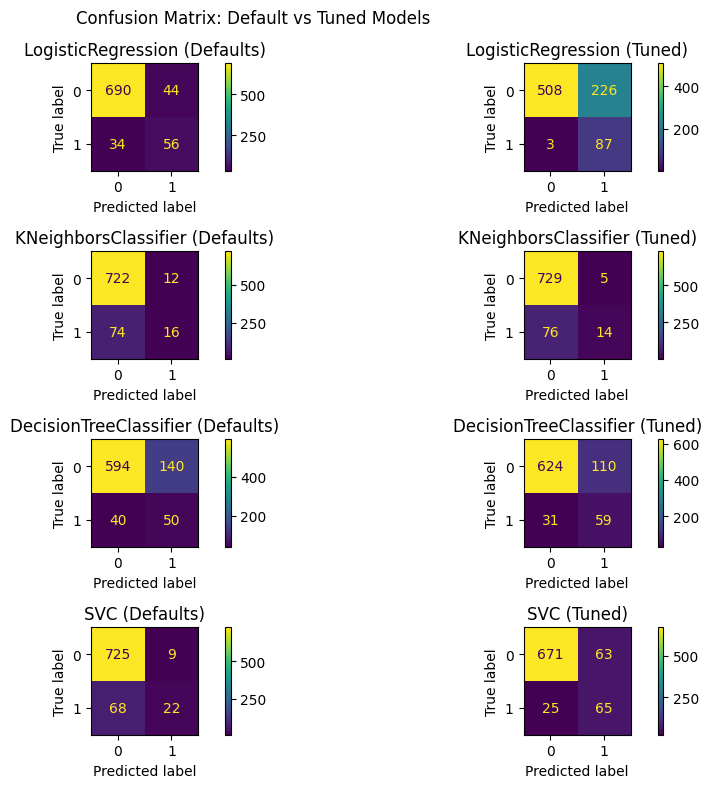

In [72]:
# Plot the default and tuned confusion matrices side-by-side

fig, axes = plt.subplots(4, 2, figsize=(Config.PAGE_WIDTH, 8))
fig.suptitle('Confusion Matrix: Default vs Tuned Models')

row = 0
for name, model in models.items():
    
    # Get the CM from the results for left and right views
    cm_l = results_defaults_df.loc[name]['cm']
    cm_r = results_tuned_df.loc[name]['cm']

    # Get the CM
    disp_l = ConfusionMatrixDisplay(cm_l)#, display_labels=['Unsuccessful', 'Successful'])
    disp_r = ConfusionMatrixDisplay(cm_r)#, display_labels=['Unsuccessful', 'Successful'])

    # plot CM
    disp_l.plot(ax=axes[row,0])
    disp_r.plot(ax=axes[row,1])

    axes[row,0].set_title(f'{name} (Defaults)')
    axes[row,1].set_title(f'{name} (Tuned)')

    row += 1

plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:  
    plt.savefig('images/confusion_matrices.png')
    
plt.show()

#### ROC Curves

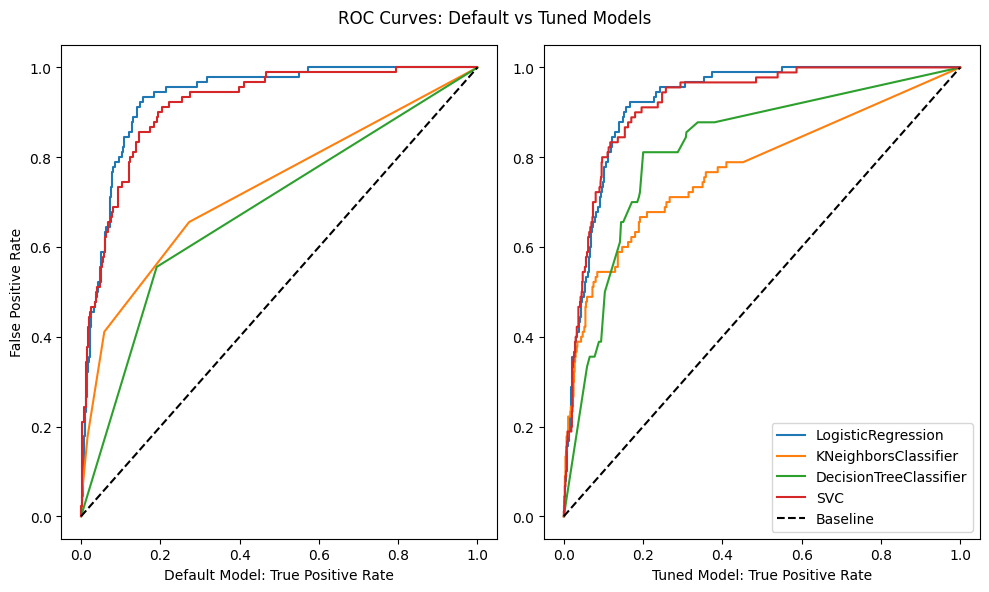

In [74]:
fig, axes = plt.subplots(1,2, figsize=(Config.PAGE_WIDTH, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

# plt.figure()
for name, model in models.items():
    probs_l = results_defaults_df.loc[name]['probs']
    probs_r = results_tuned_df.loc[name]['probs']
    fpr_l, tpr_l, threshold_l = roc_curve(y_test, probs_l)
    fpr_r, tpr_r, threshold_r = roc_curve(y_test, probs_r)
    axes[0].plot(fpr_l, tpr_l, label=name)
    axes[1].plot(fpr_r, tpr_r, label=name)

# Add the Baseline
axes[0].plot([0, 1], [0, 1], 'k--', label='Baseline')
axes[1].plot([0, 1], [0, 1], 'k--', label='Baseline')

axes[0].set_ylabel("False Positive Rate")
axes[0].set_xlabel("Default Model: True Positive Rate")
axes[1].set_xlabel("Tuned Model: True Positive Rate")
plt.suptitle("ROC Curves: Default vs Tuned Models")
plt.legend(loc="best")

plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:  
    plt.savefig('images/roc_curves.png')

plt.show()

#### Feature Importance

In [76]:
# Get feature importances from the best VotingRegressor model
feature_importances = np.zeros(X_train.shape[1])
if hasattr(best_model, 'feature_importances_'):
    feature_importances += best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    feature_importances += np.abs(best_model.coef_)  # Use absolute values for linear models

In [77]:
feature_importances

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [78]:
# Normalize the feature importances
feature_importances = feature_importances / feature_importances.sum()

# Create a DataFrame with feature names and importances
feature_names = X_train.columns
importance_summary = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_summary = importance_summary.sort_values('Importance', ascending=False).reset_index(drop=True)

/var/folders/p0/_b24zpks5fd7l2cg_53cspsh0000gn/T/ipykernel_9291/3867228724.py:2: RuntimeWarning: invalid value encountered in divide
  feature_importances = feature_importances / feature_importances.sum()


Top 10 Feature Importances from the tuned VotingRegressor:
       Feature  Importance
0          age         NaN
1          job         NaN
2      marital         NaN
3    education         NaN
4      default         NaN
5      housing         NaN
6         loan         NaN
7      contact         NaN
8        month         NaN
9  day_of_week         NaN


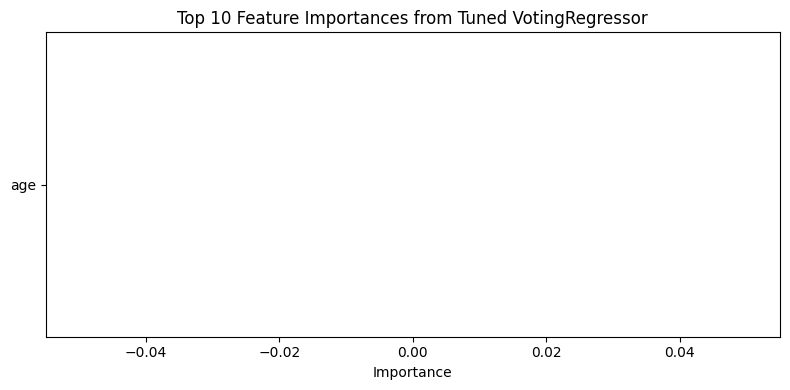

In [79]:
# Display the top 10 most important features
print("Top 10 Feature Importances from the tuned VotingRegressor:")
print(importance_summary.head(10))

# Visualize feature importances
plt.figure(figsize=(8, 4))
plt.barh(importance_summary['Feature'][:10], importance_summary['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Tuned VotingRegressor')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.tight_layout()
plt.savefig('images/feature_importance_top10.png')
plt.show()

#### Permutation Importance

In [81]:
from sklearn.inspection import permutation_importance

top_n=10
p_imp = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=Config.RANDOM_STATE)
p_imp_mean = p_imp.importances_mean
p_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': p_imp_mean})

dfi.export(p_imp_df.head(top_n), 'images/results_permutation_imp.png')

p_imp_df.sort_values(by='Importance', ascending=False).head(top_n)

02:44:29 PM DEBUG: STREAM b'IHDR' 16 13
02:44:29 PM DEBUG: STREAM b'iCCP' 41 296
02:44:29 PM DEBUG: iCCP profile name b'Skia'
02:44:29 PM DEBUG: Compression method 0
02:44:29 PM DEBUG: STREAM b'IDAT' 349 8192


,Feature,Importance
10,duration,0.084102
18,euribor3m,0.025971
14,poutcome,0.024636
16,cons.price.idx,0.015413
15,emp.var.rate,0.013956
17,cons.conf.idx,0.004976
13,previous,0.003762
3,education,0.003519
6,loan,0.002306
2,marital,0.002184


In [82]:
def plot_permutation_importance(p_imp_result, features, p_imp_mean, ax):

    perm_sorted_idx = p_imp_mean.argsort()

    ax.boxplot(
        p_imp_result.importances[perm_sorted_idx].T,
        vert=False,
        tick_labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

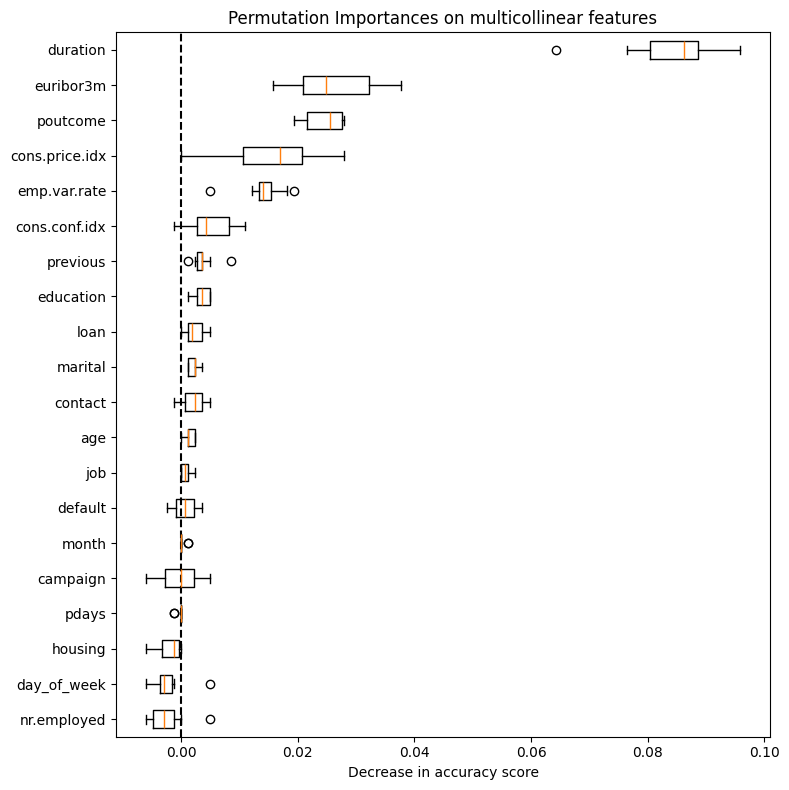

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_permutation_importance(p_imp, feature_names, p_imp_mean, ax)
ax.set_title("Permutation Importances on multicollinear features")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

plt.savefig('images/permutation_importance.png')
plt.show()

##### Questions